# Soper
Soper is a proof-of-concept of a system for tracking the spread of sentiments through social networks. It is named for George Soper, who discovered Mary Mallon ("Typhoid Mary") as the first asymptomatic carrier of typhoid fever in the United States.

Soper was inspired by [a talk](https://www.cics.umass.edu/event/spread-contagions-presence-latent-spreaders-identifying-hidden-culprits-and-learning) from [Maggie Makar](https://mymakar.github.io/).

Soper uses VADER, a sentiment analyzer specifically for social media by [C.J. Hutto](https://twitter.com/cjhutto) and [Eric Gilbert](http://eegilbert.org/).

## Imports and configuration
Nothing exciting happening here.

In [400]:
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Network initialization
In this part of the notebook, we set up the social network for our simulation.

### Friend group creation
Like real life, this social network has bunches of friends, probably connected by some common interest (school, work, hobby, etc.). In this example, all people in a group are friends with each other.

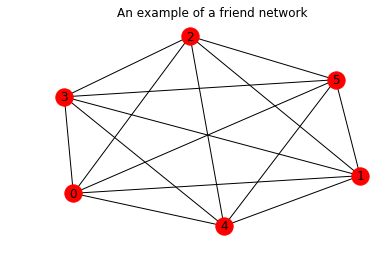

In [401]:
friend_group_count = 3
friends_per_group = 6
max_interminglings = 3

class Person(object):
    def __init__(self, id_number):
        self.id_number = id_number
        # https://homepage.stat.uiowa.edu/~mbognar/applets/normal.html
        self.gullibility = np.random.normal(loc=0.5, scale=0.1) # mean=loc,stdev=scale
        self.hostility = np.random.normal(loc=0, scale=0.2); self.hostility_temp = None
        self.activity_level = np.random.chisquare(3) / 10
        self.feed = list()
    def __str__(self):
        return str(self.id_number)
    def attitude(self):
        if self.hostility < -0.25:
            return 'neg'
        elif self.hostility > 0.25:
            return 'pos'
        else:
            return 'neu'
    def post(self):
        a = self.attitude()
        post_candidates = list()
        if a == 'pos':
            post_candidates = [
                'I\'m pretty okay with more Elbonians',
                'I LOVE Elbonian food! More Elbonians = more yummy food!',
                'I support #ElbonianRefugees because I believe in opportunity for all.',
                'The positive effects of Elbonian immigration are well-documented',
                'Elbonian culture is beautiful, especially their dances! <3',
                'My boss is an Elbonian and she\'s great!',
                'I\'m okay with Elbonians'
            ]
        elif a == 'neu':
            post_candidates = [
                '1400 Elbonian refugees have crossed the border in the past week.',
                'My father was from Elbonia.',
                'President McBasketball will address the nation tonight about the Elbonian refugees',
                'The Elbonian capitol has lots of notable architecture',
                '@FatStacksInstitute has released a new report about the effects of Elbonians on the economy',
                'Elbonian News Network (ENN) has published a new documentary on Elbonian agriculture',
                'A brief history of the Elbonian refugee issue on ViewTube: https://vwt.be/123abc',
            ]
        elif a == 'neg':
            post_candidates = [
                'I am DISGUSTED by the Elbonian pig-men.',
                'Elbonians are unpleasant and smell bad.',
                'Every Elbonian I know is RUDE!',
                'Elbonians need to LEAVE this country. GO BACK!',
                'Elbonians have freakishly small heads, probably because they are dumb.',
                'Do Elbonians make anyone else uncomfortable? :\\',
                'To be honest, I\'m not against the government\'s Elbonian ban',
            ]
        else:
            raise Error
        self.feed.append(random.choice(post_candidates))

friend_groups = list()
friend_networks = list()
all_people = list()

for group_number in range(friend_group_count):
    """
    Initialize groups of friends
    """
    
    # Create a list of friends
    lower_fence = group_number * friends_per_group
    upper_fence = lower_fence + friends_per_group
    friend_group = [Person(id_number) for id_number in range(lower_fence, upper_fence)]
    friend_groups.append(friend_group)
    
    # Create a network from the list
    friend_network = nx.Graph()
    friend_network.add_nodes_from(friend_group)
    friend_networks.append(friend_network)
    
    # Join all the members of the network together
    for friend in friend_network:
        for other_friend in friend_network:
            if other_friend is not friend:
                friend_network.add_edge(friend, other_friend)

for group in friend_groups:
    for person in group:
        all_people.append(person)

agitator = random.choice(all_people)
agitator.hostility = -1
agitator.gullibility = 0
agitator.activity_level = 1

plt.title('An example of a friend network')
nx.draw(friend_networks[0], with_labels=True)

### Overall network creation
Now, merge all the friend groups into one big social network, and add some random connections between them.

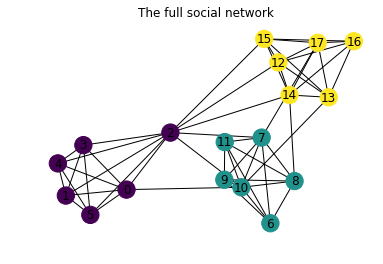

In [402]:
social_network = nx.Graph()

for friend_network in friend_networks:
    social_network.add_nodes_from(friend_network)
    social_network.add_edges_from(friend_network.edges())

for combination in itertools.combinations(friend_networks, r=2):
    fst = list(combination[0].nodes())
    snd = list(combination[1].nodes())
    for _ in range(max_interminglings):
        partner_fst = random.choice(fst)
        partner_snd = random.choice(snd)
        social_network.add_edge(partner_fst, partner_snd)

group_color_map = list()
for index, group in enumerate(friend_groups):
    for _ in range(len(group)):
        group_color_map.append(index / len(friend_groups))

plt.title('The full social network')
nx.draw(social_network, with_labels=True, node_color=group_color_map)

#### Hostility network map
This is an alternate visualization of the network, with colors signifying the individual node's hostility towards Elbonians instead of their group affiliation.

0:	-0.17466244358735653
1:	0.07793250968020801
2:	0.25579672909732226
3:	-0.1847463345971584
4:	-0.04597586299680598
5:	-0.2708778459879761
6:	-0.12603769321488498
7:	0.0931118910487701
8:	-0.16523872883379487
9:	-0.453324007213719
10:	-0.028689652566622134
11:	-0.29555676526378466
12:	0.15855347319055646
13:	-1
14:	0.3658926147204211
15:	-0.1770056987462346
16:	-0.10177791502139173
17:	0.06854581202393042


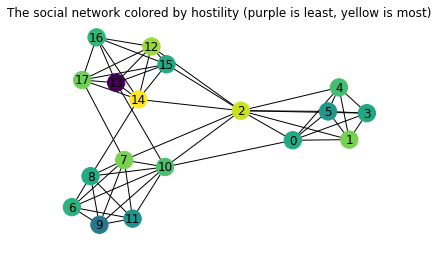

In [403]:
hostility_color_map = list()
for group in friend_groups:
    for friend in group:
        hostility_color_map.append(friend.hostility)
        print('{}:\t{}'.format(friend.id_number, friend.hostility))

plt.title('The social network colored by hostility (purple is least, yellow is most)')
nx.draw(social_network, with_labels=True, node_color=hostility_color_map)

## Simulation
This is the part of the notebook that actually runs the simulation of the social network.

In [404]:
simulation_step_count = 500

# The "data" dict helps us track change over time
data = dict()
for group in friend_groups:
    for person in group:
        data[person.id_number] = {
            'feed_length': list(),
            'hostility': list(),
        }
        person.feed = list()

for step in range(simulation_step_count):
    for group in friend_groups:
        for person in group:
            if random.random() < person.activity_level:
                person.post()
                for viewer in social_network.neighbors(person):
                    if random.random() < viewer.gullibility:
                        viewer.hostility += person.hostility / 500
            
            # update tracked data
            data[person.id_number]['feed_length'].append(len(person.feed))
            data[person.id_number]['hostility'].append(person.hostility)

### Visualizations of simulation results

In [410]:
def draw_activity_level(id_number):
    person = all_people[id_number]
    plt.title('Activity level: ' + str(person.activity_level))
    plt.ylabel('Number of posts')
    plt.xlabel('Simulation step number')
    plt.plot(data[person.id_number]['feed_length'])
    plt.show()

def draw_hostility_plot(id_number):
    person = all_people[id_number]
    plt.title('Hostility')
    plt.ylim(-1, 1)
    plt.ylabel('Hostility (-1 to 1)')
    plt.xlabel('Simulation step number')
    plt.axhspan(0.25,1,alpha=0.2,color='green')
    plt.axhspan(-1,-0.25,alpha=0.2,color='red')
    plt.plot(data[person.id_number]['hostility'])
    plt.show()

interact(draw_activity_level, id_number=(0, len(all_people) - 1))
interact(draw_hostility_plot, id_number=(0, len(all_people) - 1))

<function __main__.draw_hostility_plot>